# DMI Ocean Observations

First time: [Get API key](https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476690)

1. Create dmi = DMIOceanObsRepository(api_key=api_key)
2. Find station id from dmi.stations
3. Download data with dmi.get_observed_data()

In [1]:
%matplotlib inline
import os
api_key = os.environ["DMI_API_KEY"]
# api_key = "e11..." # Replace with correct API key

## Model result

Re-project model domain boundary to wgs84 to show on map with observations below.

In [2]:
from fmskill import ModelResult, PointObservation, Connector

m1 = ModelResult("../tests/testdata/Oresund2D.dfsu", item="Surface elevation")
m1

<DfsModelResultItem> 'Oresund2D'
File: ../tests/testdata/Oresund2D.dfsu
- Item: 0: Surface elevation <Surface Elevation> (meter)

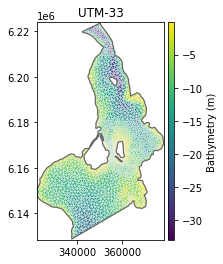

In [3]:
m1.dfs.plot(title=m1.dfs.projection_string);

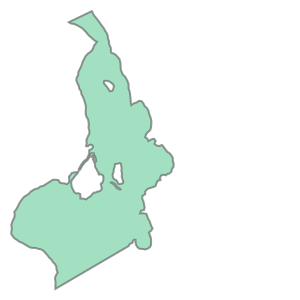

In [4]:
domain = m1.dfs.to_shapely().buffer(0)
domain

In [5]:
import pyproj

from shapely.geometry import Point
from shapely.ops import transform

wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32633') # TODO get this from projection_string

project = pyproj.Transformer.from_crs(utm,wgs84, always_xy=True).transform
geo_domain = transform(project, domain)

## Data from DMI api

In [6]:
from fmskill.data.dmi import DMIOceanObsRepository

dmi = DMIOceanObsRepository(api_key=api_key)

In [7]:
dmi.stations[dmi.stations.name.str.startswith('Kø')]

,station_id,lon,lat,name,start,end
24,30338,12.5992,55.6894,Københavns Havn,1984-12-31,1991-05-02
25,30337,12.5992,55.6894,Københavns Havn,1999-09-06,NaT
43,30478,12.1965,55.4555,Køge Havn I,2011-12-21,NaT
44,30336,12.5989,55.7043,Københavns Havn,2011-01-19,NaT
54,30479,12.1965,55.4555,Køge Havn II,2011-12-21,NaT
57,30339,12.5993,55.6896,Københavns Havn,1985-01-01,NaT
67,30337,12.5992,55.6894,Københavns Havn,1989-08-24,1999-09-06
93,30338,12.5992,55.6894,Københavns Havn,1991-05-02,NaT
99,30339,12.5993,55.6896,Københavns Havn,1974-07-18,1985-01-01
124,30336,12.5990,55.7044,Københavns Havn,2001-04-06,2011-01-19


In [8]:
import folium

map_osm = folium.Map(location=[55.5, 12.5], zoom_start=9)
dmi.stations.apply(lambda row:folium.Marker(location=[row["lat"], 
                                                  row["lon"]], popup=row["name"]).add_to(map_osm),
     axis=1)
folium.GeoJson(geo_domain, style_function = lambda x:{'fillColor': 'red', 'color': 'black'} ).add_to(map_osm)
map_osm

In [9]:
station_id = "30336" # Kbh havn

df = dmi.get_observed_data(station_id=station_id, start_time=m1.start_time, end_time=m1.end_time, limit=10000)

In [10]:
df = df.rename(columns={'sealev_dvr': 'copenhagen_harbour'})
df.head()

,copenhagen_harbour
time,
2018-03-04 00:00:00,-0.22
2018-03-04 00:10:00,-0.23
2018-03-04 00:20:00,-0.26
2018-03-04 00:30:00,-0.27
2018-03-04 00:40:00,-0.28


## Compare Observation with Model

In [11]:
# Manually move 250m to the east
# TODO: get UTM coordinates
o1 = PointObservation(df, x=350250, y=6174000) 

In [12]:
o1

PointObservation: copenhagen_harbour, x=350250, y=6174000

In [13]:
con  = Connector(o1,m1)
con

<Connector> with 
 -<PointConnector> obs=copenhagen_harbour(n=1001) :: model=Oresund2D

In [14]:
c = con.extract()
c

<ComparerCollection>
PointComparer: copenhagen_harbour

<AxesSubplot:title={'center':'copenhagen_harbour'}, ylabel='Undefined'>

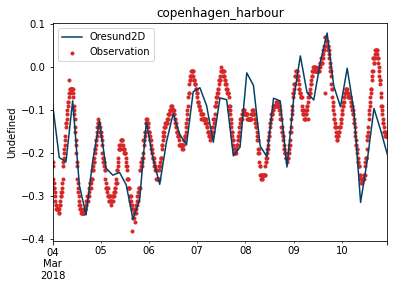

In [15]:
c[0].remove_bias()
c[0].plot_timeseries();

In [18]:
c.skill()

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
copenhagen_harbour,1001,2.262592e-17,0.053427,0.053427,0.04095,0.83732,0.304616,0.686999
